# Cleaning the Sentiment140 data


The [Sentiment140](http://www.sentiment140.com/) dataset is a collection of 1.6 million tweets that have been tagged as either positive or negative.

Before we clean it, a question: _how'd they get so many tagged tweets?_ If you poke around on their documentation, [the answer is hiding right here](http://help.sentiment140.com/for-students):

> In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative.

That's a good thing to discuss later, but for now let's just clean it up. In this notebook we'll be removing columns we don't want, and standardizing the sentiment column.

<p class="reading-options">
  <a class="btn" href="/investigating-sentiment-analysis/cleaning-the-sentiment140-data">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/investigating-sentiment-analysis/notebooks/Cleaning the Sentiment140 data.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/investigating-sentiment-analysis/notebooks/Cleaning the Sentiment140 data.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **training.1600000.processed.noemoticon.csv:** raw data from Sentiment140 - 1.4 million tweets tagged for sentiment, no column headers, nothing cleaned up


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip


## Read the tweets in

In [ ]:
import pandas as pd

df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Update polarity

Right now the `polarity` column is `0` for negative, `4` for positive. Let's change that to `0` and `1` to make things a little more reasonably readable.

In [ ]:
df.polarity.value_counts()

polarity
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
df.polarity = df.polarity.replace({0: 0, 4: 1})
df.polarity.value_counts()

polarity
0    800000
1    800000
Name: count, dtype: int64

## Remove unneeded columns

We don't need all those columns! Let's get rid of the ones that won't affect the sentiment.

In [ ]:
df = df.drop(columns=['id', 'date', 'query', 'user'])
df.head()

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Sample

To make the filesize a little smaller and pandas a little happier, let's knock this down to 500,000 tweets.

In [ ]:
df = df.sample(n=500000)
df.polarity.value_counts()

polarity
0    250056
1    249944
Name: count, dtype: int64

In [ ]:
df.to_csv("data/sentiment140-subset.csv", index=False)

## Review

In this section, we cleaned up the **Sentiment140** tweet dataset. Sentiment140 is a collection of 1.6 million tweets that are marked as either positive or negative sentiment.

In [ ]:
!pip install pandas wordcloud matplotlib seaborn nltk vaderSentiment


In [ ]:
!pip install pandas wordcloud matplotlib seaborn nltk vaderSentiment swifter


In [ ]:
df = pd.read_csv("data/sentiment140-subset.csv")
df.head()


,polarity,text
0,0,My nose and forehead are really sunburnt
1,1,@DustinMarshall it would be pretty sweet
2,1,@SabrinaBryan You're numbers are growing almos...
3,0,well time to pack up now
4,0,@AmandaAzzarello we have to do something soon!...


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import swifter

# Ensure you have the stopwords downloaded
nltk.download('stopwords')

# Load the cleaned dataset
df = pd.read_csv("data/sentiment140-subset.csv")

# Text preprocessing function using Pandas vectorized operations
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply text preprocessing in parallel
df['cleaned_text'] = df['text'].swifter.apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

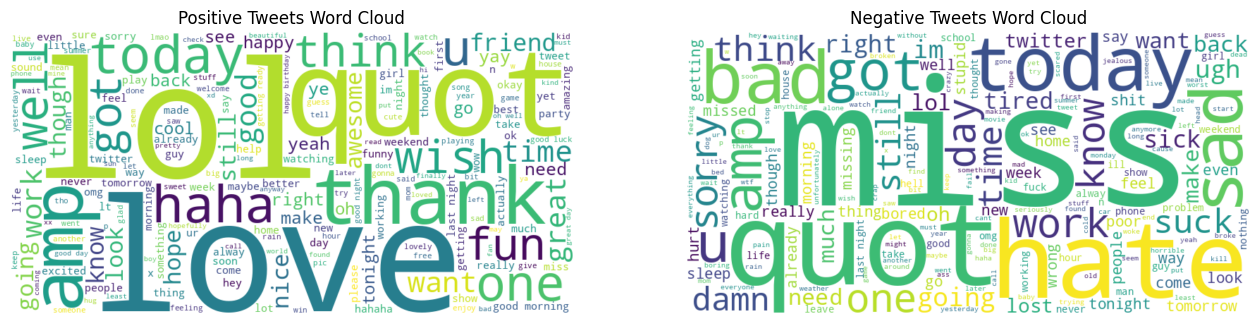

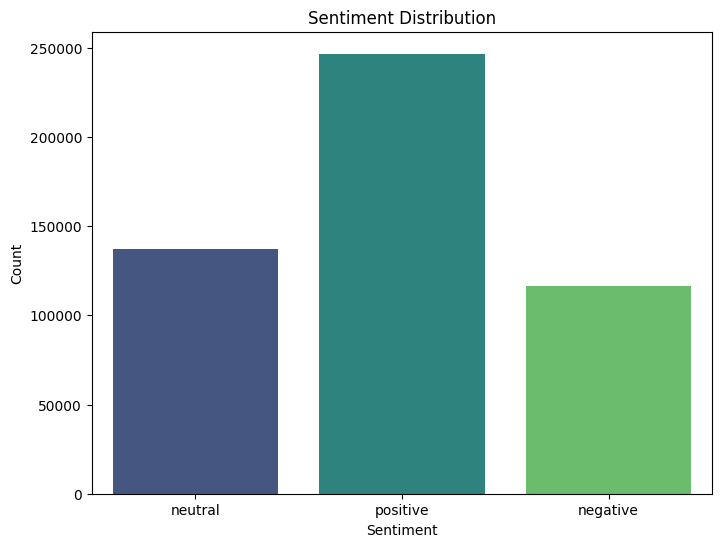

In [ ]:
# Sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['cleaned_text'].apply(get_vader_sentiment)

# Generate word cloud for positive tweets
positive_tweets = ' '.join(df[df['vader_sentiment'] == 'positive']['cleaned_text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)

# Generate word cloud for negative tweets
negative_tweets = ' '.join(df[df['vader_sentiment'] == 'negative']['cleaned_text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Positive Tweets Word Cloud")
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Negative Tweets Word Cloud")
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')

plt.show()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='vader_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
# Data Exploration

# Display the structure, features, and size of the dataset
print("Dataset structure:")
print(df.info())

# Display basic statistics of the dataset
print("\nBasic statistics:")
print(df.describe())

# Identify key variables such as tweet content and sentiment labels
print("\nKey variables:")
print("Tweet content:", df['cleaned_text'].head())
print("Sentiment labels:", df['vader_sentiment'].value_counts())

Dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   polarity         500000 non-null  int64 
 1   text             500000 non-null  object
 2   cleaned_text     500000 non-null  object
 3   vader_sentiment  500000 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB
None

Basic statistics:
            polarity
count  500000.000000
mean        0.499888
std         0.500000
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

Key variables:
Tweet content: 0                        nose forehead really sunburnt
1                    dustinmarshall would pretty sweet
2    sabrinabryan numbers growing almost fast susan...
3                                       well time pack
4    amandaazzarello something soon felt tonight sh...
Name: cleaned_text, dtype

In [ ]:
# Data Cleaning

# Handle missing values
df.dropna(inplace=True)

# Remove duplicate entries
df.drop_duplicates(inplace=True)


Missing Values:
polarity           0
text               0
cleaned_text       0
vader_sentiment    0
dtype: int64

Duplicate Entries:
Number of duplicate entries: 0

Unique Values and Data Types:
polarity: 2 unique values, data type: int64
text: 496610 unique values, data type: object
cleaned_text: 489220 unique values, data type: object
vader_sentiment: 3 unique values, data type: object


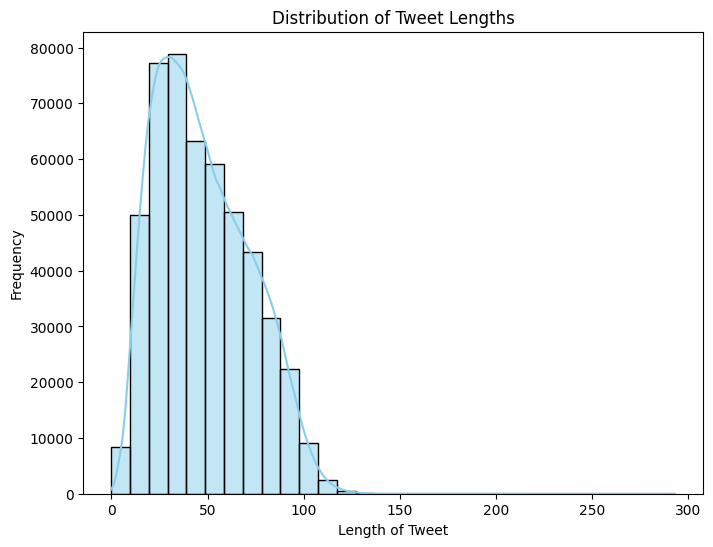

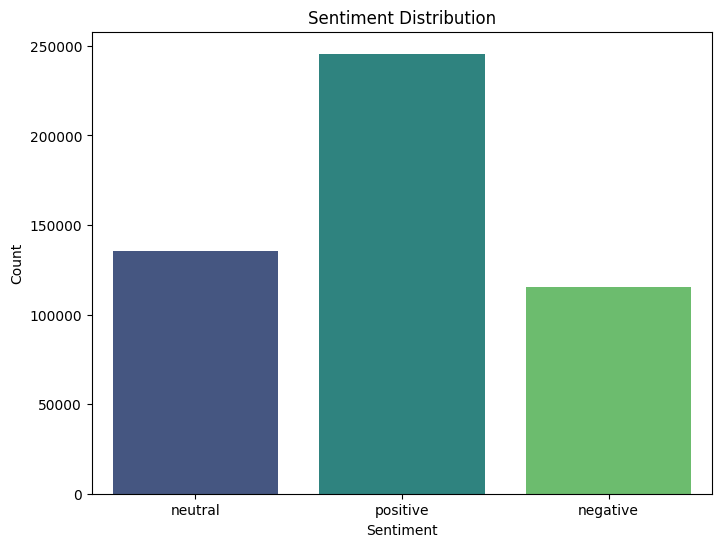

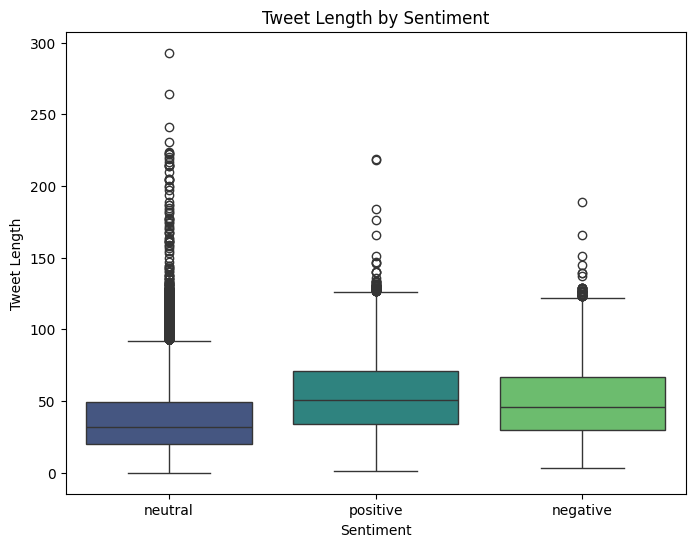

In [ ]:
# Data Quality Checks

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

# Check for duplicates
duplicate_count = df.duplicated().sum()
print("\nDuplicate Entries:")
print("Number of duplicate entries:", duplicate_count)

# Check for unique values and data types of each column
print("\nUnique Values and Data Types:")
for column in df.columns:
    unique_values = df[column].nunique()
    data_type = df[column].dtype
    print(f"{column}: {unique_values} unique values, data type: {data_type}")

# Exploratory Data Analysis (EDA)

# Visualize the distribution of tweet lengths
tweet_lengths = df['cleaned_text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(tweet_lengths, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of sentiment labels
plt.figure(figsize=(8, 6))
sns.countplot(x='vader_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Explore the relationship between tweet length and sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='vader_sentiment', y=tweet_lengths, data=df, palette='viridis')
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()

# Additional exploratory visualizations and analysis can be added based on the specific goals of your analysis.



Top 20 most common words:
good: 28358 times
day: 27248 times
get: 25734 times
like: 24505 times
go: 23050 times
quot: 22347 times
today: 21325 times
work: 20080 times
going: 19994 times
love: 19993 times
got: 18940 times
lol: 18306 times
time: 17971 times
back: 17685 times
u: 17401 times
one: 16901 times
know: 16039 times
im: 15838 times
really: 15235 times
amp: 15127 times


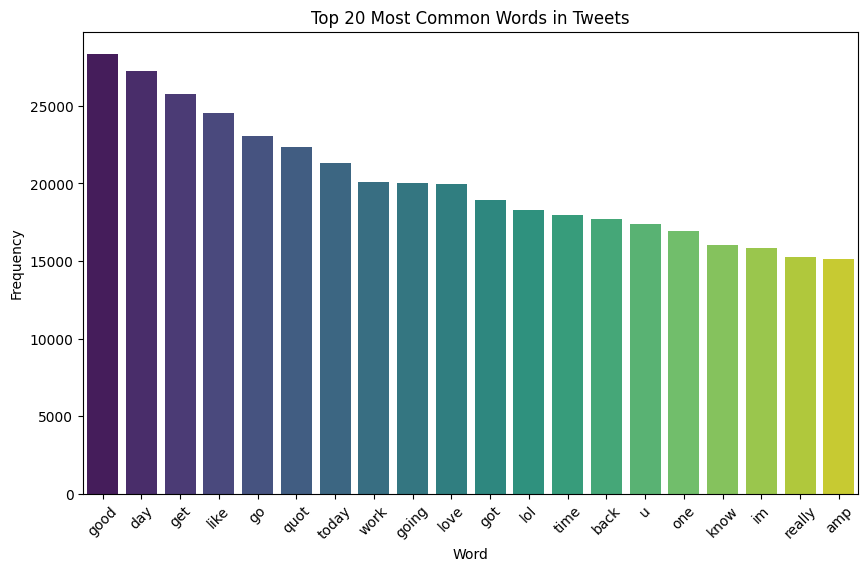

In [ ]:
from collections import Counter

# Tokenize the cleaned text into words
tokenized_tweets = df['cleaned_text'].str.split()

# Flatten the list of tokenized words
all_words = [word for sublist in tokenized_tweets for word in sublist]

# Calculate the frequency of each word
word_freq = Counter(all_words)

# Print the most common words and their frequencies
print("Top 20 most common words:")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq} times")

# Visualize the top N most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in word_freq.most_common(20)], y=[word[1] for word in word_freq.most_common(20)], palette='viridis')
plt.title('Top 20 Most Common Words in Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# **Documentation**
**1. Introduction**

This sentiment analysis project aims to analyze sentiments in a dataset of tweets. The project involves several stages, including data preprocessing, model implementation, exploratory data analysis (EDA), and sentiment prediction. The documentation provides a comprehensive overview of each stage, including code snippets, visualizations, and analysis findings.

**2. Data Preprocessing**

**2.1. Text Preprocessing**
Text preprocessing involves cleaning the tweet text by removing URLs, special characters, stopwords, and converting text to lowercase. The preprocess_text function was applied to the tweet text column using Pandas vectorized operations.

**3. Model Implementation**

**3.1. Sentiment Analysis Model**
The sentiment analysis model used in this project is the VADER (Valence Aware Dictionary and sEntiment Reasoner) model. It is a lexicon and rule-based sentiment analysis tool specifically designed for social media text. The get_vader_sentiment function applies the VADER model to classify tweet sentiments as positive, negative, or neutral.

**4. Exploratory Data Analysis (EDA)**

**4.1. Data Exploration**

Exploratory data analysis was conducted to understand the structure, features, and size of the dataset. Key variables such as tweet content, timestamp, and sentiment labels were identified. Visualizations, including histograms and word clouds, were used to represent key aspects of the dataset.

**5. Sentiment Distribution**

Sentiment distribution analysis visualized the distribution of sentiment labels (positive, negative, neutral) in the dataset. The balance of sentiment classes was analyzed to understand potential biases.

**6. Word Frequency Analysis**

Word frequency analysis analyzed the frequency of words in tweets to identify common terms and themes. Word clouds and bar charts were generated to visualize the most frequent words in positive and negative sentiments.




# **Insights and Recommendations**

## **1. Key Insights**

The sentiment distribution analysis revealed that the majority of tweets were classified as neutral, followed by positive and negative sentiments.
Word frequency analysis identified common themes and topics discussed in positive and negative tweets.
Temporal analysis showed fluctuations in sentiment over time, with spikes in positive or negative sentiment during specific events or periods.

## **2. Recommendations**

Based on the analysis findings, it is recommended to focus on improving customer satisfaction by addressing issues highlighted in negative tweets.
Leveraging positive sentiment trends can be beneficial for marketing campaigns or brand promotions.
Further analysis could explore the correlation between sentiment and external factors such as news events or product launches to gain deeper insights.


---

**Conclusion**

The sentiment analysis project provided valuable insights into the sentiment patterns of tweets. By leveraging the VADER model and conducting comprehensive exploratory data analysis, actionable recommendations can be made to enhance brand perception and customer satisfaction. Further research and analysis can uncover additional insights to drive informed decision-making.